# Multi-layer Perceptron Example

In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
print ("CURRENT TF VERSION IS [%s]" % (tf.__version__))
print ("PACKAGES LOADED")

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

CURRENT TF VERSION IS [1.15.3]
PACKAGES LOADED


## LOAD

In [2]:
# LOAD DATA
cwd = os.getcwd()
loadpath = cwd + "/data/custom_data.npz"
l = np.load(loadpath)
print (l.files)

# PARSE LOADED DATA
trainimg   = l['trainimg']
trainlabel = l['trainlabel']
testimg    = l['testimg']
testlabel  = l['testlabel']
imgsize    = l['imgsize']
categories = l['categories']
use_gray   = l['use_gray']
ntrain = trainimg.shape[0]
nclass = trainlabel.shape[1]
dim    = trainimg.shape[1]
ntest  = testimg.shape[0]
print ("%d TRAIN IMAGES" % (ntrain))
print ("%d TEST IMAGES" % (ntest))
print ("%d DIMENSIONAL INPUT" % (dim))
print ("%d CLASSES" % (nclass))
print (imgsize)
print (categories)

['trainlabel', 'imgsize', 'trainimg', 'testimg', 'testlabel', 'use_gray', 'categories']
992 TRAIN IMAGES
249 TEST IMAGES
4096 DIMENSIONAL INPUT
5 CLASSES
[64 64]
[b'al_gore' b'MS' b'liv_tyler' b'Mrs_obama' b'Apple']


## DEFINE MODEL

In [31]:
# NETWORK TOPOLOGIES
n_input    = dim
n_hidden_1 = 256 
n_hidden_2 = 128 
n_classes  = nclass  

# INPUTS AND OUTPUTS
x = tf.placeholder("float", [None, n_input])
y = tf.placeholder("float", [None, n_classes])
    
# NETWORK PARAMETERS
stddev = 0.1
weights = {
    'h1': tf.Variable(tf.random_normal([n_input, n_hidden_1], stddev=stddev)),
    'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2], stddev=stddev)),
    'out': tf.Variable(tf.random_normal([n_hidden_2, n_classes], stddev=stddev))
}
biases = {
    'b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'b2': tf.Variable(tf.random_normal([n_hidden_2])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}
print ("NETWORK READY")

NETWORK READY


## DEFINE GRAPH

In [32]:
# MODEL
def multilayer_perceptron(_X, _weights, _biases):
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(_X, _weights['h1']), _biases['b1'])) 
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, _weights['h2']), _biases['b2']))
    return (tf.matmul(layer_2, _weights['out']) + _biases['out'])

# PREDICTION
pred = multilayer_perceptron(x, weights, biases)

# LOSS AND OPTIMIZER
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=pred))
optm = tf.train.AdamOptimizer(learning_rate=0.001).minimize(cost) 
corr = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))    
accr = tf.reduce_mean(tf.cast(corr, "float"))

# INITIALIZER
init = tf.global_variables_initializer()
print ("FUNCTIONS READY")

FUNCTIONS READY


In [33]:
def plot():
    # PLOT
    ntemp = int(ntest/batch_size) + 1 
    missidxlist = []
    for ii in range(ntemp):
        iii = np.arange(ii*batch_size, min(ntest, (ii+1)*batch_size))
        feeds = {x: testimg[iii, :], y: testlabel[iii, :]}
        missidx = np.where(sess.run(corr, feed_dict=feeds) == 0)[0]
        missidxlist = np.concatenate((missidxlist, iii[missidx]))
    nmiss = len(missidxlist)
    print (" %d MISSED" % (nmiss))
    # PLOT MISSCLASSIFIED (UPTO THREE)
    missidxlist = np.random.permutation(missidxlist.astype(int))
    selmissidx  = missidxlist[:min(3, nmiss)].astype(int)
    feeds_miss  = {x: testimg[selmissidx, :], y: testlabel[selmissidx, :]}
    pred_miss   = sess.run(pred, feed_dict=feeds_miss)
    answ_miss   = np.argmax(pred_miss, 1)
    answ_corr   = np.argmax(testlabel[selmissidx, :], 1)
    for idx in range(len(selmissidx)):
        cidx = selmissidx[idx]
        anw  = answ_miss[idx]
        ref  = answ_corr[idx]
        if use_gray != 0:
            currimg = np.reshape(testimg[cidx, :], (imgsize[0], imgsize[1]))
            plt.imshow(currimg, cmap='gray')
        else:
            currimg = np.reshape(testimg[cidx, :], (imgsize[0], imgsize[1], -1))
            plt.imshow(currimg)
        anw_category = categories[anw]
        ref_category = categories[ref]
        title_string = ("IDX: %d CURR ANWR: [%s] TRUE LABEL: [%s]" 
            % (cidx, anw_category, ref_category))
        plt.title(title_string) 
        plt.show() 

def train():
    for epoch in range(training_epochs):
        total_batch = int(ntrain/batch_size)
        randpermlist = np.random.permutation(ntrain)
        sun_cost = 0.
        for i in range(total_batch):
            randidx  = randpermlist[i*batch_size:min((i+1)*batch_size, ntrain-1)]
            batch_xs = trainimg[randidx, :]
            batch_ys = trainlabel[randidx, :]                
            feeds = {x: batch_xs, y: batch_ys}
            sess.run(optm, feed_dict=feeds)
            sun_cost += sess.run(cost, feed_dict=feeds)
        avg_cost = sun_cost / total_batch

        # DISPLAY
        if (epoch+1) % disp_each == 0 or epoch == training_epochs-1:
            print ("Epoch: %03d/%03d cost: %.9f" % (epoch+1, training_epochs, avg_cost))
            feeds = {x: batch_xs, y: batch_ys}
            train_acc = sess.run(accr, feed_dict=feeds)
            print (" TRAIN ACCURACY: %.3f" % (train_acc))
            feeds = {x: testimg, y: testlabel}
            test_acc = sess.run(accr, feed_dict=feeds)
            print (" TEST ACCURACY: %.3f" % (test_acc))
            
    if (epoch+1) % plot_each == 0 or epoch == training_epochs-1:
        plot()
    

## Default : RUN TEST ACCURACY: 0.743

Epoch: 010/050 cost: 1.115537299
 TRAIN ACCURACY: 0.580
 TEST ACCURACY: 0.558
Epoch: 020/050 cost: 0.688426726
 TRAIN ACCURACY: 0.800
 TEST ACCURACY: 0.699
Epoch: 030/050 cost: 0.348958840
 TRAIN ACCURACY: 0.880
 TEST ACCURACY: 0.739
Epoch: 040/050 cost: 0.157530737
 TRAIN ACCURACY: 0.960
 TEST ACCURACY: 0.735
Epoch: 050/050 cost: 0.067917943
 TRAIN ACCURACY: 1.000
 TEST ACCURACY: 0.743
 64 MISSED


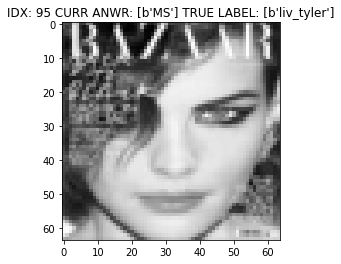

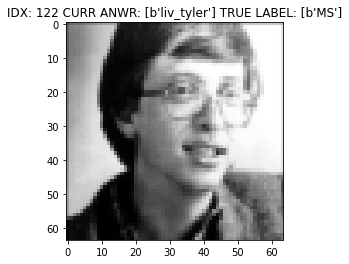

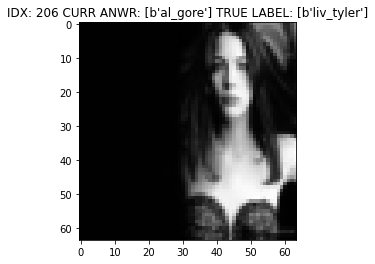

OPTIMIZATION FINISHED


In [34]:
training_epochs = 50
batch_size      = 100
disp_each       = 10
plot_each       = 10
# LAUNCH THE GRAPH
sess = tf.Session()
sess.run(init)
train()
print ("OPTIMIZATION FINISHED")

## number of hidden var change : TEST ACCURACY: 0.799

In [35]:
# NETWORK TOPOLOGIES
n_input    = dim
n_hidden_1 = 512#256
n_hidden_2 = 256#128 
n_classes  = nclass  

# INPUTS AND OUTPUTS
x = tf.placeholder("float", [None, n_input])
y = tf.placeholder("float", [None, n_classes])
    
# NETWORK PARAMETERS
stddev = 0.1
weights = {
    'h1': tf.Variable(tf.random_normal([n_input, n_hidden_1], stddev=stddev)),
    'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2], stddev=stddev)),
    'out': tf.Variable(tf.random_normal([n_hidden_2, n_classes], stddev=stddev))
}
biases = {
    'b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'b2': tf.Variable(tf.random_normal([n_hidden_2])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}
print ("NETWORK READY")

NETWORK READY


In [36]:
# MODEL
def multilayer_perceptron(_X, _weights, _biases):
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(_X, _weights['h1']), _biases['b1'])) 
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, _weights['h2']), _biases['b2']))
    return (tf.matmul(layer_2, _weights['out']) + _biases['out'])

# PREDICTION
pred = multilayer_perceptron(x, weights, biases)

# LOSS AND OPTIMIZER
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=pred))
optm = tf.train.AdamOptimizer(learning_rate=0.001).minimize(cost) 
corr = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))    
accr = tf.reduce_mean(tf.cast(corr, "float"))

# INITIALIZER
init = tf.global_variables_initializer()
print ("FUNCTIONS READY")

FUNCTIONS READY


Epoch: 010/050 cost: 0.775419090
 TRAIN ACCURACY: 0.790
 TEST ACCURACY: 0.663
Epoch: 020/050 cost: 0.258187595
 TRAIN ACCURACY: 0.970
 TEST ACCURACY: 0.759
Epoch: 030/050 cost: 0.078216822
 TRAIN ACCURACY: 0.990
 TEST ACCURACY: 0.755
Epoch: 040/050 cost: 0.022803821
 TRAIN ACCURACY: 1.000
 TEST ACCURACY: 0.795
Epoch: 050/050 cost: 0.011220674
 TRAIN ACCURACY: 1.000
 TEST ACCURACY: 0.799
 50 MISSED


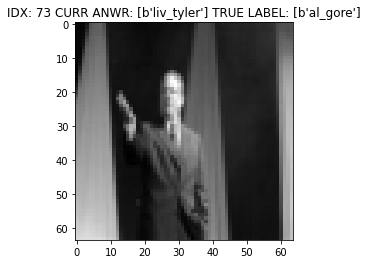

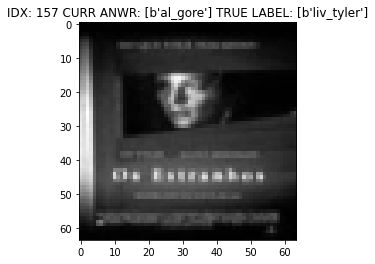

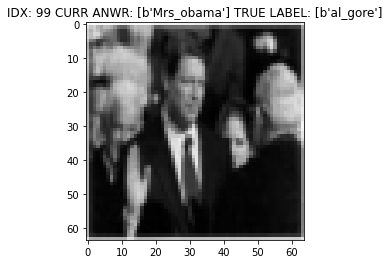

OPTIMIZATION FINISHED


In [37]:
training_epochs = 50
batch_size      = 100
disp_each       = 10
plot_each       = 10
# LAUNCH THE GRAPH
sess = tf.Session()
sess.run(init)
train()
print ("OPTIMIZATION FINISHED")

## more epochs : TEST ACCURACY: 0.783

Epoch: 010/100 cost: 0.880413546
 TRAIN ACCURACY: 0.680
 TEST ACCURACY: 0.631
Epoch: 020/100 cost: 0.394928356
 TRAIN ACCURACY: 0.880
 TEST ACCURACY: 0.715
Epoch: 030/100 cost: 0.112261221
 TRAIN ACCURACY: 0.990
 TEST ACCURACY: 0.763
Epoch: 040/100 cost: 0.046356559
 TRAIN ACCURACY: 1.000
 TEST ACCURACY: 0.771
Epoch: 050/100 cost: 0.018262869
 TRAIN ACCURACY: 1.000
 TEST ACCURACY: 0.783
Epoch: 060/100 cost: 0.010870133
 TRAIN ACCURACY: 1.000
 TEST ACCURACY: 0.787
Epoch: 070/100 cost: 0.006845196
 TRAIN ACCURACY: 1.000
 TEST ACCURACY: 0.787
Epoch: 080/100 cost: 0.004998119
 TRAIN ACCURACY: 1.000
 TEST ACCURACY: 0.783
Epoch: 090/100 cost: 0.003709393
 TRAIN ACCURACY: 1.000
 TEST ACCURACY: 0.779
Epoch: 100/100 cost: 0.002915849
 TRAIN ACCURACY: 1.000
 TEST ACCURACY: 0.783
 54 MISSED


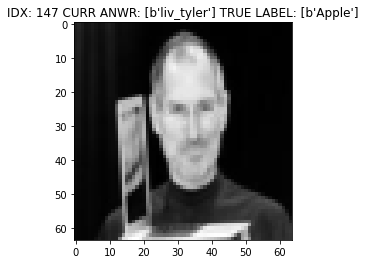

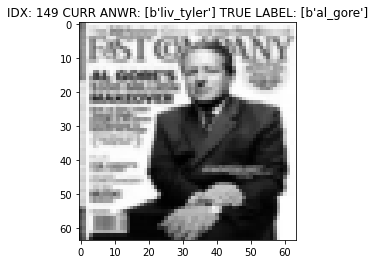

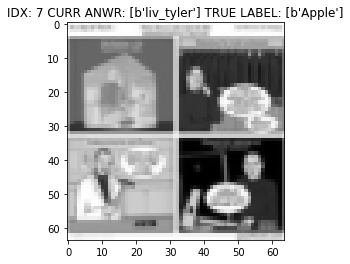

OPTIMIZATION FINISHED


In [38]:
training_epochs = 100
batch_size      = 100
disp_each       = 10
plot_each       = 10
# LAUNCH THE GRAPH
sess = tf.Session()
sess.run(init)
train()
print ("OPTIMIZATION FINISHED")

## more layers : TEST ACCURACY: 0.767

In [39]:
# NETWORK TOPOLOGIES
n_input    = dim
n_hidden_1 = 512#256
n_hidden_2 = 256#128
n_hidden_3 = 128
n_classes  = nclass  

# INPUTS AND OUTPUTS
x = tf.placeholder("float", [None, n_input])
y = tf.placeholder("float", [None, n_classes])
    
# NETWORK PARAMETERS
stddev = 0.1
weights = {
    'h1': tf.Variable(tf.random_normal([n_input, n_hidden_1], stddev=stddev)),
    'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2], stddev=stddev)),
    'h3': tf.Variable(tf.random_normal([n_hidden_2, n_hidden_3], stddev=stddev)),
    'out': tf.Variable(tf.random_normal([n_hidden_3, n_classes], stddev=stddev))
}
biases = {
    'b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'b2': tf.Variable(tf.random_normal([n_hidden_2])),
    'b3': tf.Variable(tf.random_normal([n_hidden_3])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}
print ("NETWORK READY")

NETWORK READY


In [40]:
# MODEL
def multilayer_perceptron(_X, _weights, _biases):
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(_X, _weights['h1']), _biases['b1'])) 
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, _weights['h2']), _biases['b2']))
    layer_3 = tf.nn.sigmoid(tf.add(tf.matmul(layer_2, _weights['h3']), _biases['b3']))
    return (tf.matmul(layer_3, _weights['out']) + _biases['out'])

# PREDICTION
pred = multilayer_perceptron(x, weights, biases)

# LOSS AND OPTIMIZER
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=pred))
optm = tf.train.AdamOptimizer(learning_rate=0.001).minimize(cost) 
corr = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))    
accr = tf.reduce_mean(tf.cast(corr, "float"))

# INITIALIZER
init = tf.global_variables_initializer()
print ("FUNCTIONS READY")

FUNCTIONS READY


Epoch: 010/050 cost: 1.060916762
 TRAIN ACCURACY: 0.620
 TEST ACCURACY: 0.590
Epoch: 020/050 cost: 0.473311050
 TRAIN ACCURACY: 0.890
 TEST ACCURACY: 0.679
Epoch: 030/050 cost: 0.131090422
 TRAIN ACCURACY: 0.980
 TEST ACCURACY: 0.759
Epoch: 040/050 cost: 0.036315236
 TRAIN ACCURACY: 0.990
 TEST ACCURACY: 0.747
Epoch: 050/050 cost: 0.015413080
 TRAIN ACCURACY: 1.000
 TEST ACCURACY: 0.767
 58 MISSED


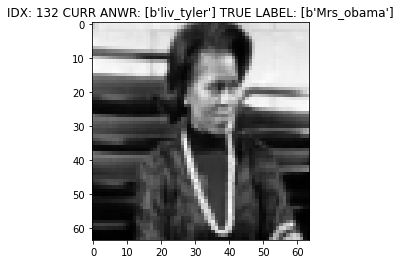

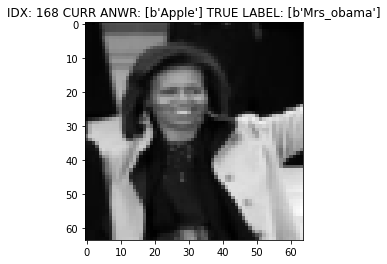

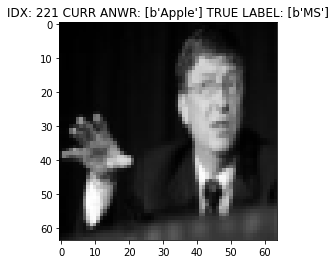

OPTIMIZATION FINISHED


In [41]:
training_epochs = 50
batch_size      = 100
disp_each       = 10
plot_each       = 10
# LAUNCH THE GRAPH
sess = tf.Session()
sess.run(init)
train()
print ("OPTIMIZATION FINISHED")

## Swish Activation func : TEST ACCURACY: 0.803

In [42]:
# NETWORK TOPOLOGIES
n_input    = dim
n_hidden_1 = 512#256
n_hidden_2 = 256#128 
n_classes  = nclass  

# INPUTS AND OUTPUTS
x = tf.placeholder("float", [None, n_input])
y = tf.placeholder("float", [None, n_classes])
    
# NETWORK PARAMETERS
stddev = 0.1
weights = {
    'h1': tf.Variable(tf.random_normal([n_input, n_hidden_1], stddev=stddev)),
    'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2], stddev=stddev)),
    'out': tf.Variable(tf.random_normal([n_hidden_2, n_classes], stddev=stddev))
}
biases = {
    'b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'b2': tf.Variable(tf.random_normal([n_hidden_2])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}
print ("NETWORK READY")

NETWORK READY


In [43]:
# MODEL
def multilayer_perceptron(_X, _weights, _biases):
    layer_1 = tf.nn.swish(tf.add(tf.matmul(_X, _weights['h1']), _biases['b1'])) 
    layer_2 = tf.nn.swish(tf.add(tf.matmul(layer_1, _weights['h2']), _biases['b2']))
    return (tf.matmul(layer_2, _weights['out']) + _biases['out'])

# PREDICTION
pred = multilayer_perceptron(x, weights, biases)

# LOSS AND OPTIMIZER
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=pred))
optm = tf.train.AdamOptimizer(learning_rate=0.001).minimize(cost) 
corr = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))    
accr = tf.reduce_mean(tf.cast(corr, "float"))

# INITIALIZER
init = tf.global_variables_initializer()
print ("FUNCTIONS READY")

FUNCTIONS READY


Epoch: 010/050 cost: 0.547782610
 TRAIN ACCURACY: 0.820
 TEST ACCURACY: 0.691
Epoch: 020/050 cost: 0.142445881
 TRAIN ACCURACY: 0.970
 TEST ACCURACY: 0.779
Epoch: 030/050 cost: 0.044798520
 TRAIN ACCURACY: 1.000
 TEST ACCURACY: 0.799
Epoch: 040/050 cost: 0.015427502
 TRAIN ACCURACY: 1.000
 TEST ACCURACY: 0.775
Epoch: 050/050 cost: 0.007437293
 TRAIN ACCURACY: 1.000
 TEST ACCURACY: 0.803
 49 MISSED


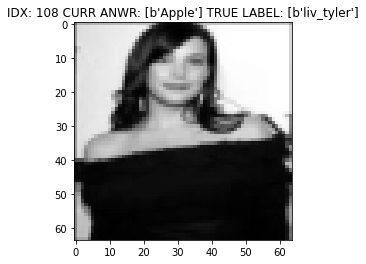

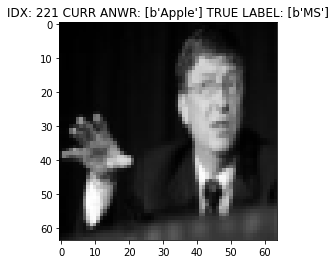

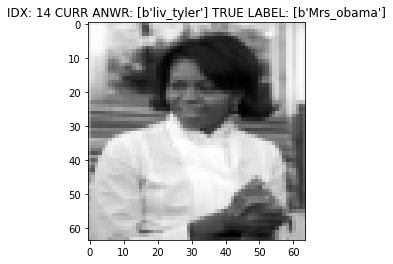

OPTIMIZATION FINISHED


In [44]:
training_epochs = 50
batch_size      = 100
disp_each       = 10
plot_each       = 10
# LAUNCH THE GRAPH
sess = tf.Session()
sess.run(init)
train()
print ("OPTIMIZATION FINISHED")

## Residual connection : TEST ACCURACY: 0.751

In [51]:
# NETWORK TOPOLOGIES
n_input    = dim
n_hidden_1 = 512#256
n_hidden_2 = 512#128 
n_classes  = nclass  

# INPUTS AND OUTPUTS
x = tf.placeholder("float", [None, n_input])
y = tf.placeholder("float", [None, n_classes])
    
# NETWORK PARAMETERS
stddev = 0.1
weights = {
    'h1': tf.Variable(tf.random_normal([n_input, n_hidden_1], stddev=stddev)),
    'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2], stddev=stddev)),
    'out': tf.Variable(tf.random_normal([n_hidden_2, n_classes], stddev=stddev))
}
biases = {
    'b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'b2': tf.Variable(tf.random_normal([n_hidden_2])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}
print ("NETWORK READY")

NETWORK READY


In [52]:
# MODEL
def multilayer_perceptron(_X, _weights, _biases):
    layer_1 = tf.nn.swish(tf.add(tf.matmul(_X, _weights['h1']), _biases['b1']))
    layer_2 = tf.nn.swish(tf.add(tf.matmul(layer_1, _weights['h2']), _biases['b2']))
    layer_2 = tf.add(layer_2, layer_1)
    return (tf.matmul(layer_2, _weights['out']) + _biases['out'])

# PREDICTION
pred = multilayer_perceptron(x, weights, biases)

# LOSS AND OPTIMIZER
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=pred))
optm = tf.train.AdamOptimizer(learning_rate=0.001).minimize(cost) 
corr = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))    
accr = tf.reduce_mean(tf.cast(corr, "float"))

# INITIALIZER
init = tf.global_variables_initializer()
print ("FUNCTIONS READY")

FUNCTIONS READY


Epoch: 010/050 cost: 0.510573751
 TRAIN ACCURACY: 0.850
 TEST ACCURACY: 0.659
Epoch: 020/050 cost: 0.116797493
 TRAIN ACCURACY: 0.990
 TEST ACCURACY: 0.759
Epoch: 030/050 cost: 0.031648016
 TRAIN ACCURACY: 1.000
 TEST ACCURACY: 0.775
Epoch: 040/050 cost: 0.013999277
 TRAIN ACCURACY: 1.000
 TEST ACCURACY: 0.763
Epoch: 050/050 cost: 0.007314980
 TRAIN ACCURACY: 1.000
 TEST ACCURACY: 0.751
 62 MISSED


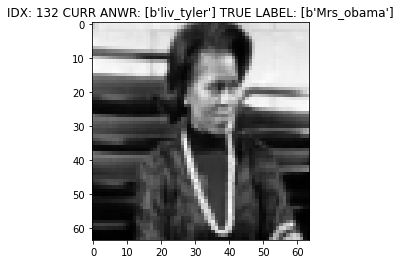

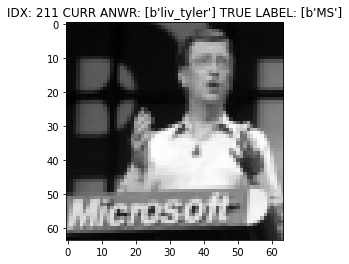

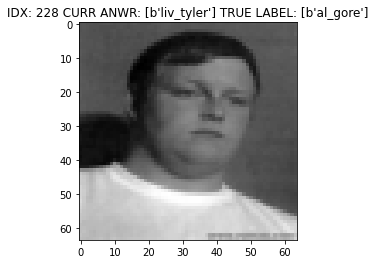

OPTIMIZATION FINISHED


In [53]:
training_epochs = 50
batch_size      = 100
disp_each       = 10
plot_each       = 10
# LAUNCH THE GRAPH
sess = tf.Session()
sess.run(init)
train()
print ("OPTIMIZATION FINISHED")

## Modify Learning rate : TEST ACCURACY: 0.779

In [54]:
# NETWORK TOPOLOGIES
n_input    = dim
n_hidden_1 = 512#256
n_hidden_2 = 256#128 
n_classes  = nclass  

# INPUTS AND OUTPUTS
x = tf.placeholder("float", [None, n_input])
y = tf.placeholder("float", [None, n_classes])
    
# NETWORK PARAMETERS
stddev = 0.1
weights = {
    'h1': tf.Variable(tf.random_normal([n_input, n_hidden_1], stddev=stddev)),
    'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2], stddev=stddev)),
    'out': tf.Variable(tf.random_normal([n_hidden_2, n_classes], stddev=stddev))
}
biases = {
    'b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'b2': tf.Variable(tf.random_normal([n_hidden_2])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}
print ("NETWORK READY")

NETWORK READY


In [55]:
# MODEL
def multilayer_perceptron(_X, _weights, _biases):
    layer_1 = tf.nn.swish(tf.add(tf.matmul(_X, _weights['h1']), _biases['b1'])) 
    layer_2 = tf.nn.swish(tf.add(tf.matmul(layer_1, _weights['h2']), _biases['b2']))
    return (tf.matmul(layer_2, _weights['out']) + _biases['out'])

# PREDICTION
pred = multilayer_perceptron(x, weights, biases)

# LOSS AND OPTIMIZER
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=pred))
optm = tf.train.AdamOptimizer(learning_rate=0.005).minimize(cost) 
corr = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))    
accr = tf.reduce_mean(tf.cast(corr, "float"))

# INITIALIZER
init = tf.global_variables_initializer()
print ("FUNCTIONS READY")

FUNCTIONS READY


Epoch: 010/050 cost: 0.490386688
 TRAIN ACCURACY: 0.900
 TEST ACCURACY: 0.711
Epoch: 020/050 cost: 0.105397166
 TRAIN ACCURACY: 1.000
 TEST ACCURACY: 0.775
Epoch: 030/050 cost: 0.019385952
 TRAIN ACCURACY: 1.000
 TEST ACCURACY: 0.767
Epoch: 040/050 cost: 0.007675680
 TRAIN ACCURACY: 1.000
 TEST ACCURACY: 0.779
Epoch: 050/050 cost: 0.004359705
 TRAIN ACCURACY: 1.000
 TEST ACCURACY: 0.779
 55 MISSED


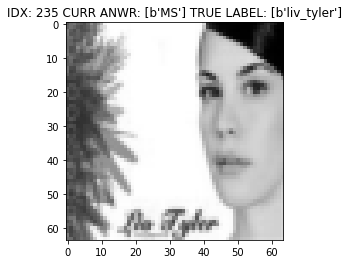

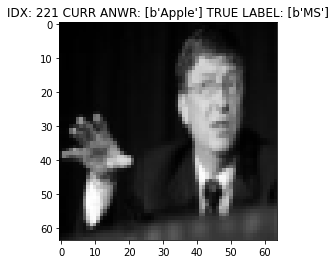

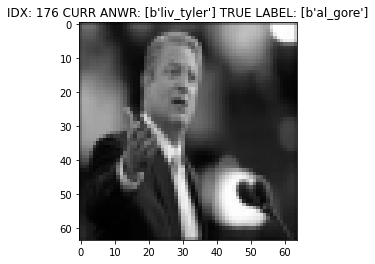

OPTIMIZATION FINISHED


In [56]:
training_epochs = 50
batch_size      = 100
disp_each       = 10
plot_each       = 10
# LAUNCH THE GRAPH
sess = tf.Session()
sess.run(init)
train()
print ("OPTIMIZATION FINISHED")